In [5]:
!python -m spacy download en

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from gensim.corpora import Dictionary
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import LdaModel
import pyLDAvis.gensim_models
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from tqdm.notebook import tqdm
import random
import numpy as np
import torch

In [7]:
data = []
with open('datasets/text.txt') as f:
    for line in f.readlines():
        text, emotion = line.strip().split(';')
        data.append({'text': text, 'emotion': emotion})
data = pd.DataFrame(data)

In [8]:
print('number of samples:', len(data))
data.head(10)

number of samples: 20000


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


set of unique emotions: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


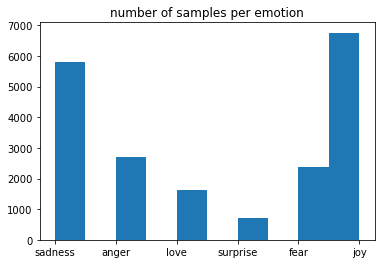

In [9]:
n_classes = len(set(data['emotion']))
print('number of different classes:', n_classes)
print('set of unique emotions:', data['emotion'].unique())
plt.hist(data['emotion'])
plt.title('number of samples per emotion')
plt.show()

In [10]:
def text_reformat(text):
    """lowercase without punctuation"""
    import re
    return re.sub(r'[^\w\s]', '', text.lower())

print('Removing punctuation and converting to lowercase..')
data['text'] = data['text'].apply(text_reformat)

Removing punctuation and converting to lowercase..


<BarContainer object of 2 artists>

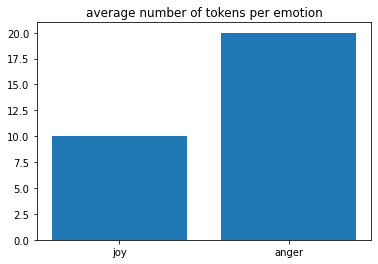

In [11]:
plt.title('average number of tokens per emotion')
plt.bar(['joy', 'anger'], [10, 20])

In [12]:
"""tokenize and lemmatize text, and remove stopwords"""
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
all_stopwords = spacy.lang.en.stop_words.STOP_WORDS

def tokens(s: str):
    return [t.text for t in nlp(s) if t.text not in all_stopwords]

text_tokens = [tokens(t) for t in tqdm(data['text'], desc="tokenize")]
data.insert(2, 'text_tokens', text_tokens)

example = "nick likes to play football however he is not too fond of tennis"
example_tokens = tokens(example)

print('Before tokenizing:', example)
print('After tokenizing:', example_tokens)

tokenize:   0%|          | 0/20000 [00:00<?, ?it/s]

Before tokenizing: nick likes to play football however he is not too fond of tennis
After tokenizing: ['nick', 'likes', 'play', 'football', 'fond', 'tennis']


average number of tokens in a document: 8.3312
[8.053993444885286, 8.338501291989663, 8.896404631322364, 8.58692628650904, 8.200168563000421, 8.447566927969236]


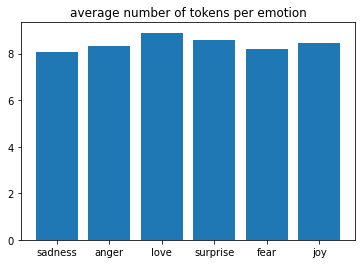

In [13]:
avg_num_tokens = sum(len(t) for t in text_tokens) / len(text_tokens)

print('average number of tokens in a document:', avg_num_tokens)

avg_tokens = []
for emotion in data['emotion'].unique():
    df = data[data['emotion'] == emotion]
    avg_tokens.append(sum(len(x) for x in df['text_tokens'].tolist()) / len(df))
print(avg_tokens)

plt.title('average number of tokens per emotion')
plt.bar(data['emotion'].unique(), avg_tokens)
plt.show()

In [14]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_tokens)

# Filter out words that occur less than in 5 documents, or more than in 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("dictionary word with index 20:", dictionary[20])

dictionary word with index 20: little


In [15]:
# Convert tokenized documents into bag-of-words (BOW) representation: (word index, word count)
corpus = [dictionary.doc2bow(doc) for doc in text_tokens]
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))#%%

Example of BOW representation: [(0, 1), (1, 1)]
Number of unique tokens: 3648
Number of documents: 20000


In [16]:
# train LDA model
lda = LdaModel(
    corpus,  # documents in BOW format
    id2word=dictionary.id2token,  # id -> word mapping to make topics interpretable
    num_topics=6,  # desired number of topics
    passes=30,  # number of iterations
)

# look at the topics
print("LDA topics:")
lda.print_topics()

LDA topics:


[(0,
  '0.056*"like" + 0.027*"nt" + 0.021*"m" + 0.019*"people" + 0.014*"know" + 0.014*"s" + 0.011*"think" + 0.011*"want" + 0.008*"feels" + 0.008*"things"'),
 (1,
  '0.048*"t" + 0.040*"like" + 0.025*"know" + 0.024*"nt" + 0.021*"don" + 0.015*"want" + 0.015*"love" + 0.014*"s" + 0.012*"feelings" + 0.011*"look"'),
 (2,
  '0.044*"feeling" + 0.033*"m" + 0.033*"like" + 0.024*"nt" + 0.012*"going" + 0.010*"time" + 0.009*"find" + 0.009*"things" + 0.008*"write" + 0.007*"want"'),
 (3,
  '0.143*"feeling" + 0.066*"m" + 0.021*"little" + 0.015*"ve" + 0.015*"bit" + 0.012*"day" + 0.010*"today" + 0.009*"days" + 0.009*"pretty" + 0.008*"left"'),
 (4,
  '0.034*"like" + 0.016*"life" + 0.012*"friends" + 0.011*"time" + 0.009*"moment" + 0.009*"people" + 0.008*"blessed" + 0.008*"ve" + 0.008*"s" + 0.007*"able"'),
 (5,
  '0.044*"feeling" + 0.017*"http" + 0.015*"href" + 0.014*"m" + 0.009*"generous" + 0.008*"glad" + 0.008*"ok" + 0.007*"confident" + 0.007*"s" + 0.007*"time"')]

In [17]:
import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.198576  0.083009       1        1  24.356666
1     -0.217978  0.104750       2        1  18.178701
0     -0.145913  0.071074       3        1  17.930536
2      0.034020  0.156093       4        1  15.455258
4     -0.130752 -0.305858       5        1  12.939136
5      0.262046 -0.109070       6        1  11.139704, topic_info=        Term         Freq        Total Category  logprob  loglift
5    feeling  6176.000000  6176.000000  Default  30.0000  30.0000
182        t  1148.000000  1148.000000  Default  29.0000  29.0000
27      like  3531.000000  3531.000000  Default  28.0000  28.0000
10         m  3507.000000  3507.000000  Default  27.0000  27.0000
232      don   509.000000   509.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
52         s   103.756760   937.033963   Topic6  -4.9556  -0.0060
39     years    75.780129   172.402999   Topic6  -5.2698   1.3727
54      time    98.190863   977.657415   Topic6  -5.0107  -0.1036
621    right    78.913009   448.430002   Topic6  -5.2293   0.4572
407    happy    73.662866   317.786679   Topic6  -5.2982   0.7328

[333 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
106       1  0.146399        able
106       2  0.248435        able
106       4  0.075418        able
106       5  0.527923        able
169       3  0.984779  acceptable
...     ...       ...         ...
39        1  0.133408       years
39        2  0.237815       years
39        5  0.191412       years
39        6  0.440828       years
317       3  0.992556       young

[411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5, 6])

In [18]:
X = data['text']

le = LabelEncoder()
y = le.fit_transform(data['emotion'])
class_labels = [le.inverse_transform([i])[0] for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (13400,)
X_test shape: (6600,)


In [19]:
vec = TfidfVectorizer(stop_words='english', max_features = 3000, ngram_range = (1, 3))
vec.fit(X_train)
X_train_vecs = vec.transform(X_train).todense().tolist()
X_test_vecs = vec.transform(X_test).todense().tolist()

In [20]:
clf = SGDClassifier(max_iter=100, penalty='l1')

clf.fit(X_train_vecs, y_train)
print("Accuracy score on train:", accuracy_score(y_train, clf.predict(X_train_vecs)))
print("Accuracy score on test:", accuracy_score(y_test, clf.predict(X_test_vecs)))

Accuracy score on train: 0.8862686567164179
Accuracy score on test: 0.8534848484848485


In [ ]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.005, 0.0001, 0.0005, 0.00001],
    'max_iter': [50, 100, 500, 1000]
}
# parameters = {
#     'random_state': [0, 10, 100],
#     'loss': ('log', 'hinge'),
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'alpha': [0.001, 0.0001],
#     'max_iter': [10, 100, 1000,]
# }

grid_search = GridSearchCV(SGDClassifier(), parameters, scoring='accuracy')
grid_search.fit(X_train_vecs, y_train)

print("Accuracy score on train:", accuracy_score(y_train, grid_search.predict(X_train_vecs)))
print("Accuracy score on test:", accuracy_score(y_test, grid_search.predict(X_test_vecs)))
print("The best model parameters are:", grid_search.best_estimator_)

In [22]:
class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.xh = nn.Linear(input_size, hidden_size)
        self.hy = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        self.hidden_size = hidden_size

    def forward(self, x, h):
        hidden = self.relu(self.hh(h) + self.xh(x))
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    rnn.zero_grad()
    hidden = rnn.h0()

    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

In [ ]:
random.seed(0)

n_hidden = 64
rnn = ClassificationRNN(len(X_train_vecs[0]), n_hidden, len(set(y_train)))

n_iters = 13400 * 10
print_every = 1000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    idx = random.randint(0, len(X_train) - 1)
    
    input_tensor, target_tensor = torch.tensor([X_train_vecs[idx]]), torch.tensor([y_train[idx]])
    
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, target_tensor, input_tensor, 0.0005)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/134000 [00:00<?, ?it/s]

Intel MKL FATAL ERROR: This system does not meet the minimum requirements for use of the Intel(R) Math Kernel Library.
The processor must support the Intel(R) Supplemental Streaming SIMD Extensions 3 (Intel(R) SSSE3) instructions.
The processor must support the Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) instructions.
The processor must support the Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/Emotions-dataset-for-NLP/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Emotions-dataset-for-NLP/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Emotions-dataset-for-NLP/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Emotions-dataset-for-NLP/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt

In [ ]:
plt.title('loss in terms of number of iterations')
plt.plot(iterations, losses)
plt.show()

In [ ]:
def evaluate(rnn, name_tensor):
    hidden = rnn.h0()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    return output

def predict(input_vec, n_predictions=1):
    with torch.no_grad():
        output = evaluate(rnn, torch.tensor(input_vec))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, le.inverse_transform([category_index])))
            predictions.append([value, le.inverse_transform([category_index])])

In [ ]:
# for i in range(100):
#     print(predict([X_test_vecs[i]]), le.inverse_transform([y_test[i]]))